# Importy

In [1]:
import locale

import csv
import os

import numpy as np
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as random
from IPython.display import Image as JupyterImage, display, clear_output

# Nastaveni

In [2]:
def sigmoida(phi):
    return np.round(1.0 / (1.0 + np.exp(-phi)), 15)

speed = 0.05 #rychlost učení
inertia = 0.2 #setrvačnost


# Percepton

In [3]:
class Percepton:
    def __init__(self, num_outputs, num_inputs, activation):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.w = np.zeros((num_outputs, num_inputs))
        self.th = np.zeros(num_outputs)
        self.activation_function = activation
        self.delta = np.zeros(num_outputs)
        self.dws = np.zeros((num_outputs, num_inputs))
        self.odw = np.zeros((num_outputs, num_inputs))
        self.dths = np.zeros(num_outputs)
        self.odth = np.zeros(num_outputs)
        self.outputs = np.zeros(num_outputs) #Y - outputs from Perceptron

    def outputDelta(self, d):
        # deltai = (di - yi) * (yi * (1 - yi))
        diff = d - self.outputs
        self.delta = diff * (self.outputs * (1 - self.outputs))
        return diff @ diff / len(self.outputs)

    def learn(self, xInputs):
        # self.dws += self.delta * xInputs
        for i in range(len(self.dws)):
            self.dws[i] += self.delta[i] * xInputs

        self.dths += -self.delta

    def backPropagate(self, prevLayer):
        # print('out', np.transpose(self.w) @ self.delta)
        prevLayer.delta = (np.transpose(self.w) @ self.delta) * (prevLayer.outputs * (1 - prevLayer.outputs))

    def epochStart(self):
        self.dws = np.zeros((self.num_outputs, self.num_inputs))
        self.dths = np.zeros(self.num_outputs)
        self.outputs = np.zeros(self.num_outputs)

    def epochFinish(self):
        dws_temp = speed * self.dws + inertia * self.odw
        self.w += dws_temp
        self.odw = dws_temp

        dths_temp = speed * self.dths + inertia * self.odth
        self.th += dths_temp
        self.odth = dths_temp

    def recall(self, inputs_array):
        self.outputs = self.activation_function(self.w @ inputs_array - self.th)
        return self.outputs

    def init(self, randon_range_min, randon_range_max):
        for x in range(len(self.w)):
            for y in range(len(self.w[x])):
                self.w[x][y] = random.uniform(randon_range_max, randon_range_min)

        for x in range(len(self.th)):
            self.th[x] = random.uniform(randon_range_max, randon_range_min)

# Net

In [4]:
class Net:
    def __init__(self):
        self.layers = []
        self.output = []

    def recall(self, x):
        self.layers[0].recall(x)
        return self.layers[1].recall(self.layers[0].outputs)

    def netInit(self, randon_range_min, randon_range_max):
        self.layers = []
        self.layers.append(Percepton(25, 25, sigmoida))
        self.layers.append(Percepton(19, 25, sigmoida))
        self.output = self.layers[1]
        for l in self.layers:
            l.init(randon_range_min, randon_range_max)
        # self.layers[0].w[0][0] = -  0.214767760000000
        # self.layers[0].w[0][1] = -  0.045404790000000
        # self.layers[0].w[1][0] =    0.106739550000000
        # self.layers[0].w[1][1] =    0.136999780000000
        # self.layers[0].th[0]   = -  0.299236760000000
        # self.layers[0].th[1]   =    0.122603690000000
        # self.layers[1].w[0][0] =    0.025870070000000
        # self.layers[1].w[0][1] =    0.168638190000000
        # self.layers[1].th[0]   =    0.019322390000000

    def epochStart(self):
        for l in self.layers:
            l.epochStart()

    def epochFinish(self):
        for l in self.layers:
            l.epochFinish()

    def learn(self, x, d):
        self.recall(x)
        e = self.layers[1].outputDelta(d)
        # print('mse', e)
        self.layers[1].learn(self.layers[0].outputs)
        self.layers[1].backPropagate(self.layers[0])
        self.layers[0].learn(x)
        return e

    def print_net(self):
        print("%1.15f" % self.layers[1].outputs[0] + ";output:y")
        print("%1.15f" % self.layers[1].th[0] + ";output:threshold")
        print("%1.15f" % self.layers[1].w[0][0] + ";output:w[0]")
        print("%1.15f" % self.layers[1].w[0][1] + ";output:w[1]")
        print("%1.15f" % self.layers[1].delta[0] + ";output:delta")
        print("%1.15f" % self.layers[1].dths[0] + ";output:deltathreshold")
        print("%1.15f" % self.layers[1].dws[0][0] + ";output:deltaw[0]")
        print("%1.15f" % self.layers[1].dws[0][1] + ";output:deltaw[1]")
        print("%1.15f" % self.layers[0].outputs[0] + ";hidden:y[0]")
        print("%1.15f" % self.layers[0].outputs[1] + ";hidden:y[1]")
        print("%1.15f" % self.layers[0].th[0] + ";hidden:threshold[0]")
        print("%1.15f" % self.layers[0].th[1] + ";hidden:threshold[1]")
        print("%1.15f" % self.layers[0].w[0][0] + ";hidden:w[0][0]")
        print("%1.15f" % self.layers[0].w[0][1] + ";hidden:w[0][1]")
        print("%1.15f" % self.layers[0].w[1][0] + ";hidden:w[1][0]")
        print("%1.15f" % self.layers[0].w[1][1] + ";hidden:w[1][1]")
        print("%1.15f" % self.layers[0].delta[0] + ";hidden:delta[0]")
        print("%1.15f" % self.layers[0].delta[1] + ";hidden:delta[1]")
        print("%1.15f" % self.layers[0].dths[0] + ";hidden:deltathreshold[0]")
        print("%1.15f" % self.layers[0].dths[1] + ";hidden:deltathreshold[1]")
        print("%1.15f" % self.layers[0].dws[0][0] + ";hidden:deltaw[0][0]")
        print("%1.15f" % self.layers[0].dws[0][1] + ";hidden:deltaw[0][1]")
        print("%1.15f" % self.layers[0].dws[1][0] + ";hidden:deltaw[1][0]")
        print("%1.15f" % self.layers[0].dws[1][1] + ";hidden:deltaw[1][1]")
        # print("%1.15f" % self.layers[0].oth[0] + ";hidden:old delta threshold [0]")
        # print("%1.15f" % self.layers[0].oth[1] + ";hidden:old delta threshold [1]")
        print("%1.15f" % self.layers[0].odw[0][0] + ";hidden:olddeltaw[0][0]")
        print("%1.15f" % self.layers[0].odw[0][1] + ";hidden:olddeltaw[0][1]")
        print("%1.15f" % self.layers[0].odw[1][0] + ";hidden:olddeltaw[1][0]")
        print("%1.15f" % self.layers[0].odw[1][1] + ";hidden:olddeltaw[1][1]")

# Init

In [5]:
def normalize(value, min, max):
    return (value - min) / (max - min)



net = Net()
net.netInit(-0.5, 0.5)

# Dataset

In [6]:
filename = 'imgs.data'
raw_data = open(filename, 'rt')
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
x = list(reader)

trainSet = []

def parse_img(url, width, height):
    img = Image.open(url)
    img = img.convert('L')
    img = img.resize((width, height), Image.ANTIALIAS)
    img = np.array(img, dtype=np.float)
    return img

for item in x:
    if len(item) > 0:
        label = list(item[1])
        label = np.array(label, dtype=np.float)

        img = parse_img("./imgs/"+ item[0], 5, 5)
        img = np.concatenate(img)
        img = normalize(img, 0, 255)
        
        print(label)
        display(JupyterImage(filename="imgs/"+ item[0]))

        trainSet.append(
                  [
                      img,
                      label,
                      item[0]
                  ])


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Learn

EPOCH: 20001
Error: 5.04847251221429e-05


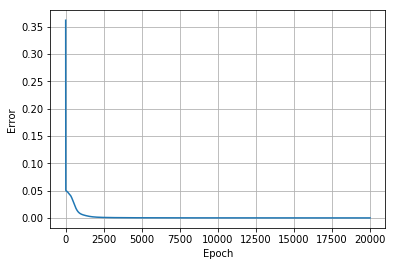

EPOCH: 20170
Error: 4.99993595891612e-05


In [7]:
rms = []
epoch = []
avgErr = 0
err = 0
for i in range(50000):
    avgErr = 0
    net.epochStart()
    for pat in trainSet:
        avgErr += net.learn(pat[0], pat[1])
    net.epochFinish()
    err = avgErr/len(trainSet)

    if err < 0.00005:
        print("EPOCH:", i + 1)
        print("Error:", err)
        print("========================")
        break

    rms.append( err )
    epoch.append(i + 1)

    if i % 200 == 0:
        clear_output()
        print("EPOCH:", i + 1)
        print("Error:", err)
        fig, axs = plt.subplots(1, 1)
        axs.plot(epoch, rms)
        axs.set_xlabel('Epoch')
        axs.set_ylabel('Error')
        axs.grid(True)
        plt.show()
        

# RMS graf

In [8]:
# fig, axs = plt.subplots(1, 1)
# axs.plot(epoch, rms)
# axs.set_xlabel('Epoch')
# axs.set_ylabel('Error')
# axs.grid(True)
# plt.show()

# Ověření

In [9]:
def print_result(it):
    print("Train set   :"+str(trainSet[it][1])+" :")
    print("After learn :"+str(np.round(net.recall(trainSet[it][0]))))
    #print("Real        :"+str(net.recall(trainSet[it][0])))
    print("=====")    



for i in range(19):
    print_result(i)


Train set   :[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
After learn :[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
=====
Train set   :[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
After learn :[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
=====
Train set   :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
After learn :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
=====
Train set   :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
After learn :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
=====
Train set   :[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
After learn :[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
=====
Train set   :[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
After learn :[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
=====
Train set   :[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] :
After learn :[

# Stickman

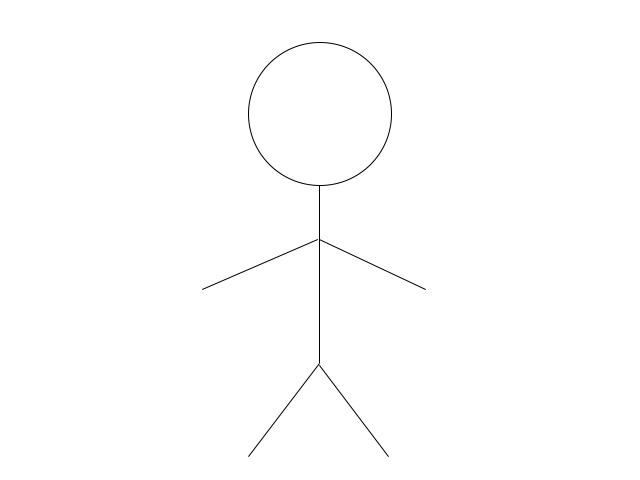

In [10]:
IMG_URL = "./imgs/stickman.png"
WIDTH = 640
HEIGHT = 480
display(JupyterImage(filename=IMG_URL))

## Prohledání stickmana

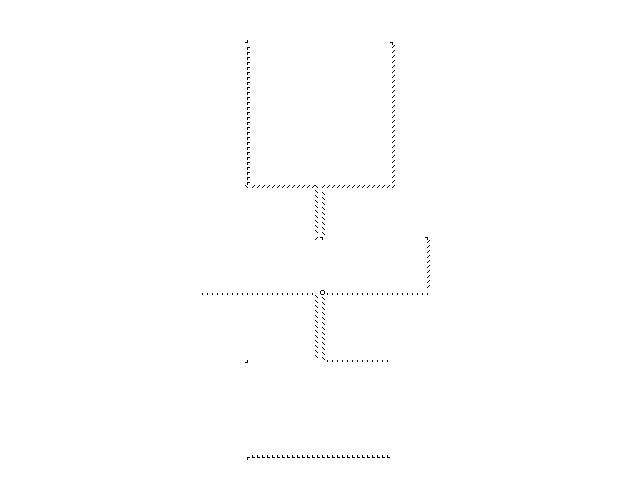

In [11]:
#Load real stickman
stickman_arr = parse_img(IMG_URL, WIDTH, HEIGHT)

#Prepare blank image
result_img = Image.new('RGB', (WIDTH, HEIGHT), (255, 255, 255))

def get_image_window(column_param, height_param, size):
    result = np.zeros((size, size))
    c = 0
    r = 0
    
    for column in range(column_param, column_param + size):
        r = 0
        for row in range(height_param, height_param + size):
            result[c][r] = stickman_arr[row][column]
            r += 1
        c += 1
            
    return np.array(result)
        
SCAN_WINDOW = 5

for column in range(0, (WIDTH), SCAN_WINDOW):
    for row in range(0, (HEIGHT), SCAN_WINDOW):
        img = get_image_window(column, row, SCAN_WINDOW)
        img = np.concatenate(img)
        img = normalize(img, 0, 255)
        result = np.round(net.recall(img))
        result = np.where(result == 1.0)[0]
        if len(result) > 0:
#             print(result[0])  
            result_img.paste(Image.open("./imgs/"+str(result[0])+".png"), (column, row))
    


#Display result
display(result_img)
